In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from matplotlib import pyplot as plt
import datetime
import json


# Process Configuration

In [8]:
# Customization

# Set the path to the main directory containing the training and testing folders
main_dir = './dataset'

# Define the subdirectories
train_dir = main_dir + '/training'
test_dir = main_dir + '/testing'
logs_dir = "./logs"

# Set the desired image settings
image_width = 1450
image_height = 291
image_size = (image_width, image_height)
resize_factor = 0.8  # Reduce photo size by 20%
batch_size = 16

# Specify the exact names of the two classes (two directories) located in both subdirectories
class_names = ['bottleneck', 'non_bottleneck']
epochs = 3


In [9]:

print('_________________________________________________________')
print(f'Main directory is set to {main_dir}')
print(f'Training subdirectory is set to {train_dir}')
print(f'Testing subdirectory is set to {test_dir}')
print('_________________________________________________________')
print(f'Image width: {image_width}')
print(f'Image height: {image_height}')
print(f'Image will be resized to {resize_factor*100}% of its original size')
print('_________________________________________________________')
print(f'Batch size: {batch_size}')
print(f'Number of training cycles (epochs): {epochs}')
print('_________________________________________________________')


_________________________________________________________
Main directory is set to ./dataset
Training subdirectory is set to ./dataset/training
Testing subdirectory is set to ./dataset/testing
_________________________________________________________
Image width: 1450
Image height: 291
Image will be resized to 80.0% of its original size
_________________________________________________________
Batch size: 16
Number of training cycles (epochs): 3
_________________________________________________________


## Creating a dataset from images

In [10]:



# Create the training dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    class_names=class_names,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True
)

# Create the testing dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    class_names=class_names,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=False
)




# Apply a function to the datasets using the map() method
# Normalize pixel values to [0, 1]
train_dataset = train_dataset.map(lambda x, y: (x / 255.0, y))
test_dataset = test_dataset.map(lambda x, y: (x / 255.0, y))


reduced_image_size = (int(image_size[0] * resize_factor), int(image_size[1] * resize_factor))

# Resize images in the datasets
train_dataset = train_dataset.map(lambda x, y: (tf.image.resize(x, reduced_image_size), y))
test_dataset = test_dataset.map(lambda x, y: (tf.image.resize(x, reduced_image_size), y))


Found 113 files belonging to 2 classes.
Found 103 files belonging to 2 classes.


## Model Architecture

In [11]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(reduced_image_size[0], reduced_image_size[1], 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


2023-05-31 04:10:29.341671: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 253034496 exceeds 10% of free system memory.
2023-05-31 04:10:29.614754: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 253034496 exceeds 10% of free system memory.


## Compiling the model

In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


## Training the model

In [13]:
history = model.fit(train_dataset, epochs=epochs, batch_size=batch_size)

2023-05-31 04:10:30.405337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [113]
	 [[{{node Placeholder/_0}}]]
2023-05-31 04:10:30.406710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [113]
	 [[{{node Placeholder/_4}}]]


Epoch 1/3
8/8 [==============================] - 62s 7s/step - loss: 6.5958 - accuracy: 0.5487
Epoch 2/3
8/8 [==============================] - 56s 7s/step - loss: 0.5547 - accuracy: 0.7434
Epoch 3/3
8/8 [==============================] - 56s 7s/step - loss: 0.6373 - accuracy: 0.6991


## Testing the model

In [22]:
# Evaluate the model on the test dataset
testing_loss, testing_accuracy = model.evaluate(test_dataset)

print(f'Test Loss: {testing_loss}, Test Accuracy: {testing_accuracy}')

7/7 [==============================] - 7s 960ms/step - loss: 0.5081 - accuracy: 0.7573
Test Loss: 0.5080534815788269, Test Accuracy: 0.7572815418243408


## Saving the logs

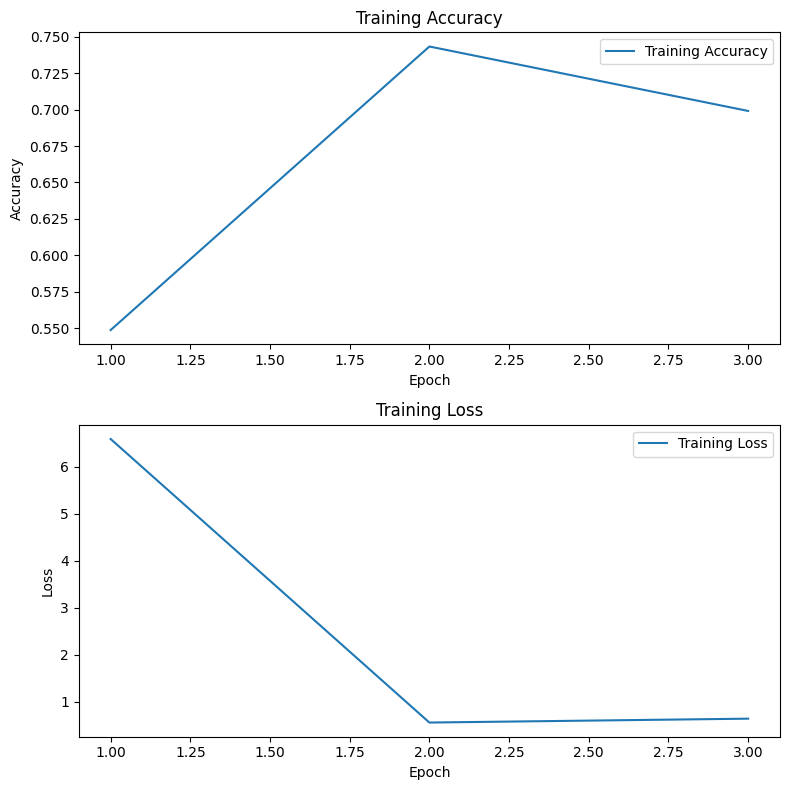

In [23]:

# Access the accuracy and loss values from the history object
training_accuracy = history.history['accuracy']
training_loss = history.history['loss']

# Create subplots for accuracy and loss
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

# Plot accuracy
ax1.plot(range(1, len(training_accuracy) + 1), training_accuracy, label='Training Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Training Accuracy')
ax1.legend()

# Plot loss
ax2.plot(range(1, len(training_loss) + 1), training_loss, label='Training Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Training Loss')
ax2.legend()

plt.tight_layout()

# Save the figure
plt.savefig(f'{logs_dir}/training_plot.png')


In [24]:
logs = {
    "Time": {
        "date":datetime.datetime.now().strftime('%D'),
        "time":datetime.datetime.now().strftime('%T')
    },
    
    "DIR-Config": {
        "Main DIR": main_dir,
        "Training SUB-DIR": train_dir,
        "Testing SUB-DIR": test_dir
    },
    
    "Image-Config": {
        "Image width":image_width,
        "Image height":image_height,
        "Image resize":resize_factor
    },
    
    "Training Config": {
        "Batch size": batch_size,
        "Epochs": epochs,
    },
    
    "MODEL OUT": {
      "Training Loss":training_loss[-1],
      "Training Accuracy":training_accuracy[-1],
      "Training Progress": [f"Epoch {epoch+1}: Accuracy = {training_accuracy[epoch]}, Loss = {training_loss[epoch]}" for epoch in range(len(training_accuracy))],

      "Testing Loss":testing_loss,
      "Testing Accuracy": testing_accuracy,

    }
    
}

# Write the data to json file
with open(f"{logs_dir}/zabbix_logs.json", "a") as json_file:
    json.dump(logs, json_file)

## Saving the model

In [25]:
model.save('./MK-1')

INFO:tensorflow:Assets written to: ./MK-1/assets


INFO:tensorflow:Assets written to: ./MK-1/assets
